In [6]:
import sys
sys.path.append("..")  # to make utils importable
import utils.data_loader
import numpy
import bs4
import utils.consts
import networkx

In [7]:
dataset = utils.data_loader.load_dataset()


def parse_html(html_row: str) -> str:
    return bs4.BeautifulSoup(html_row, "html.parser").get_text(separator=" ")


dataset["Body"] = dataset["Body"].apply(parse_html)
dataset = dataset[utils.consts.COLS_TO_KEEP + ["ParentId"]]

Data loaded


In [49]:
graph = networkx.Graph()

users = dataset.OwnerUserId.dropna().unique()
questions = dataset[dataset.PostTypeId == 1]
answers = dataset[dataset.PostTypeId == 2]

# tags
user_to_tags = {user : set() for user in users}
question_to_tags = {}
for i in range(len(questions)):
    question = questions.iloc[i]
    if question.Tags is not None:
        question_to_tags[question.Id] = set(question.Tags)

for i in range(len(answers)):
    answer = answers.iloc[i]
    if not numpy.isnan(answer.OwnerUserId) and answer.Tags is not None:
        user_to_tags[answer.OwnerUserId] |= set(answer.Tags)

# users
user_attributes = {}
for user in users:
    graph.add_node('u' + str(user))
    user_attributes[user] = {"type": "user", "tags": user_to_tags[user]}
networkx.set_node_attributes(graph, user_attributes)

# questions
question_attributes = {}
for i in range(len(questions)):
    question = questions.iloc[i]
    graph.add_node('q' + str(question.Id))
    question_attributes[question.Id] = {"type": "question", "tags": question_to_tags[question.Id], "score": question.Score}
networkx.set_node_attributes(graph, question_attributes)

# min-max normalization
min_ = questions.Score.min()
max_ = questions.Score.max()

# user-question
for i in range(len(questions)):
    question = questions.iloc[i]
    graph.add_edge('u' + str(question.OwnerUserId), 'q' + str(question.ParentId), weight=(question.Score - min_) / (max_ - min_))

# user-user
for user1 in users:
    for user2 in users:
        if not numpy.isnan(user1) and not numpy.isnan(user2) and user1 < user2:
            user1_tags = user_to_tags[user1]
            user2_tags = user_to_tags[user2]
            if len(user1_tags | user2_tags) * len(user1_tags & user2_tags) == 0:
                continue
            w = (len(user1_tags & user2_tags) / len(user1_tags | user2_tags))
            if w >= 0.95:
                graph.add_edge(user1, user2, weight=w)

# question-question
for i in range(len(questions)):
    for j in range(len(questions)):
        if i < j:
            question1 = questions.iloc[i].Id
            question2 = questions.iloc[j].Id
            question1_tags = question_to_tags[question1]
            question2_tags = question_to_tags[question2]
            if len(question1_tags | question2_tags) * len(question1_tags & question2_tags) == 0:
                continue
            w = (len(question1_tags & question2_tags) / len(question1_tags | question2_tags))
            if w >= 0.95:
                graph.add_edge(question1, question2, weight=w)

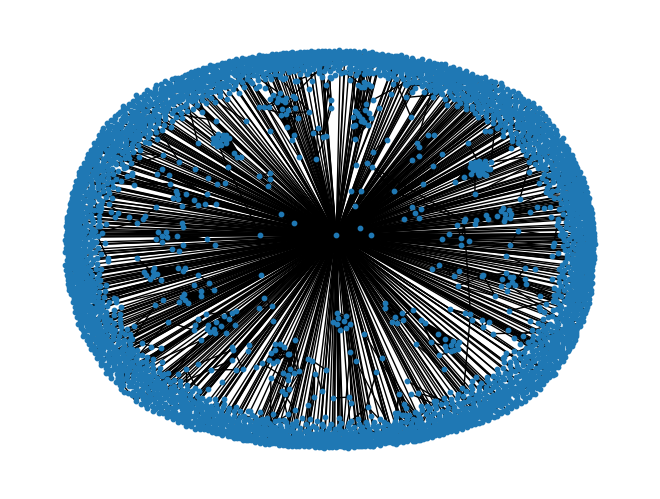

In [50]:
pos = networkx.spring_layout(graph, k=0.15, iterations=50)

networkx.draw(graph, pos, node_size=10, width=1, alpha=1.0)